# Imbalance evaluation

## Imports

In [ ]:
import os
from torch import utils
import torch
import numpy as np
import pandas as pd
from sklearn import ensemble
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from sklearn import tree, svm
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from src.utils.const import DATA_DIR, SEED
from src.utils.util_models import fix_random
from src.visualization.visualize import barplot_multiple_columns, show_class_distribution
from sklearn.metrics import f1_score

### Useful path to data

In [ ]:
ROOT_DIR = os.path.join(os.getcwd(), '..')
PROCESSED_DIR = os.path.join(ROOT_DIR, DATA_DIR, 'processed')

### Fix random seed

In [ ]:
fix_random(SEED)

## Read final dataset

In [ ]:
final = pd.read_parquet(os.path.join(PROCESSED_DIR, 'final.parquet'))

### Add rating_discrete feature

In [ ]:
final = (final
         .assign(rating_discrete=pd.cut(final.loc[:, 'rating_mean'], bins=10, labels=False))
         .astype({'rating_discrete': 'int32'})
         .drop(columns=['rating_mean']))
final.info()

## Showing the imbalance

### Separate train/test

In [ ]:
data = final.loc[:, final.columns != 'rating_discrete']
target = final['rating_discrete']
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2,
                                                                    stratify=final['rating_discrete'])

### Show class distribution

In [ ]:
distribution = train_target.reset_index().groupby('rating_discrete').agg('count').reset_index()\
    .rename(columns={'index': 'count'})

labels = [f'{round(i, 2)}-{round(i + 0.45, 2)}' for i in np.arange(0.5, 5, 0.45)]

In [ ]:
barplot_multiple_columns(['Train set'], labels, distribution['count'], 'Class distribution')

In [ ]:
show_class_distribution(train_target)

## Test function definition

### Models

In [ ]:
models = {'random_forest': ensemble.RandomForestClassifier(),
          'decision_tree': tree.DecisionTreeClassifier(),
          'gaussian_nb': GaussianNB(),
          'quadratic_discriminant': QuadraticDiscriminantAnalysis(store_covariance=True),
          'svm': svm.SVC()
          }

### Test function

In [ ]:
def try_sample(df:pd.DataFrame,train_data_inside, train_target_inside, test_data_inside, test_target_inside, balance: str) -> pd.DataFrame:
    # Define evaluation procedure (here we use Repeated Stratified K-Fold CV)

    cv = StratifiedKFold(n_splits=3)
    # Evaluate model
    scoring = ['f1_weighted']

    for elm in models.items():
        scores = cross_validate(elm[1], train_data_inside, train_target_inside, scoring=scoring, cv=cv, n_jobs=-1,
                                return_estimator=True)

        #gathering best estimator from cross validation
        best_estimator_index = np.argmax(scores['test_f1_weighted'])
        estimator = scores['estimator'][best_estimator_index]

        # testing the estimator
        y_pred = estimator.predict(test_data_inside)
        f1_test = f1_score(test_target_inside, y_pred, average='weighted')

        # summarize performance
        new_sample = pd.DataFrame(
            {'balance': [balance], 'model_name': [elm[0]], 'mean_f1_val': [np.mean(scores['test_f1_weighted'])],
             'f1_score_test': [f1_test]})
        df = pd.concat([df, new_sample])

    print(df[df['balance'] == balance])

    return df

## Transformations

In [ ]:
features = [
    'year',
    'title_length',
    'runtime',
    'rating_count',
    'tag_count'
]

scaler = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('minmax', MinMaxScaler(), features)
    ])

pipe = Pipeline(steps=[
    ('scaler', scaler)
])

pipe.fit(train_data)
train_data_proc = pipe.transform(train_data)
test_data_proc = pipe.transform(test_data)

### balancer MLP

TODO (?)

In [ ]:
def balancer(train_target_tmp: np.ndarray) -> utils.data.WeightedRandomSampler:
    counts = np.bincount(train_target_tmp)
    if counts.any(0):
        np.seterr(divide='ignore')
        labels_weights = 1. / counts
        labels_weights[np.isinf(labels_weights)] = 0
    else:
        np.seterr(divide=None)
        labels_weights = 1. / counts
    weights = torch.tensor(labels_weights[train_target_tmp], dtype=torch.float)
    return utils.data.WeightedRandomSampler(weights, len(weights), replacement=True)

## Use imbalanced-learn methods

## Define dataframe

In [ ]:
df=pd.DataFrame({})

### SMOTE

In [ ]:
smt = SMOTE(k_neighbors=4)
train_data_smt_proc, train_target_smt_proc = smt.fit_resample(train_data_proc, train_target)
df=try_sample(df,train_data_smt_proc, train_target_smt_proc, test_data_proc, test_target, 'SMOTE')

### SMOTETomek

In [ ]:
smt_tom = SMOTETomek(smote=SMOTE(k_neighbors=4), tomek=TomekLinks(sampling_strategy='majority'))
train_data_smt_tom, train_target_smt_tom = smt_tom.fit_resample(train_data, train_target)
df=try_sample(df,train_data_smt_tom, train_target_smt_tom, test_data_proc, test_target, 'SMOTETomek')

### SMOTEENN

In [ ]:
smt_enn = SMOTEENN(smote=SMOTE(k_neighbors=4), enn=EditedNearestNeighbours(n_neighbors=4))
train_data_smt_enn_proc, train_target_smt_enn_proc = smt_enn.fit_resample(train_data_proc, train_target)
df=try_sample(df,train_data_smt_enn_proc, train_target_smt_enn_proc, test_data_proc, test_target, 'SMOTEENN')

### RandomOverSampler

In [ ]:
rnd_over = RandomOverSampler()
train_data_rnd_over_proc, train_target_rnd_over_proc = rnd_over.fit_resample(train_data_proc, train_target)
df=try_sample(df,train_data_rnd_over_proc, train_target_rnd_over_proc, test_data_proc, test_target, 'RandomOverSampler')

### SMOTE with threshold

#### Calculate min threshold

In [ ]:
bins_count = train_target.value_counts()
for i in range(len(bins_count)):
    if bins_count[i] <= 500:
        bins_count[i] = 500

bin_sizes = bins_count.to_dict()

In [ ]:
smt_new = SMOTE(k_neighbors=4, sampling_strategy=bin_sizes)
train_data_smt_new, train_target_smt_new = smt_new.fit_resample(train_data_proc, train_target)
df=try_sample(df,train_data_smt_new, train_target_smt_new, test_data_proc, test_target, 'SMOTE_threshold')

## Comparison between models

It is necessary to prepare the datas as follow:
- for each row it must contains the values of each group, since we have 5 groups it must contains 5 elements
- the number of rows must be equal to the number of columns of each group

In [ ]:
data = []
for elm in df['balance'].unique():
    data.append(df[df['balance'] == elm]['f1_score_test'].to_numpy())

In [ ]:
barplot_multiple_columns(df['model_name'].unique(), df['balance'].unique(), data,
                         'Comparison of balancing strategy between models')

## Show class distribution with the best balancing method

In [ ]:
show_class_distribution(train_target_smt_tom)

#### Calculate min threshold

In [19]:
bins_count = train_target.value_counts()
for i in range(len(bins_count)):
    if bins_count[i] <= 500:
        bins_count[i] = 500

bin_sizes = bins_count.to_dict()

In [20]:
smt_new = SMOTE(k_neighbors=4, sampling_strategy=bin_sizes)
train_data_smt_new, train_target_smt_new = smt_new.fit_resample(train_data_proc, train_target)
df=try_sample(df,train_data_smt_new, train_target_smt_new, test_data_proc, test_target, 'SMOTE_threshold')

           balance              model_name  mean_f1_val  f1_score_test
0  SMOTE_threshold           random_forest     0.791930       0.736491
0  SMOTE_threshold           decision_tree     0.692480       0.635978
0  SMOTE_threshold             gaussian_nb     0.524201       0.432130
0  SMOTE_threshold  quadratic_discriminant     0.403113       0.270797
0  SMOTE_threshold                     svm     0.826344       0.773328


## Comparison between models

It is necessary to prepare the datas as follow:
- for each row it must contains the values of each group, since we have 5 groups it must contains 5 elements
- the number of rows must be equal to the number of columns of each group

In [21]:
data = []
for elm in df['balance'].unique():
    data.append(df[df['balance'] == elm]['f1_score_test'].to_numpy())

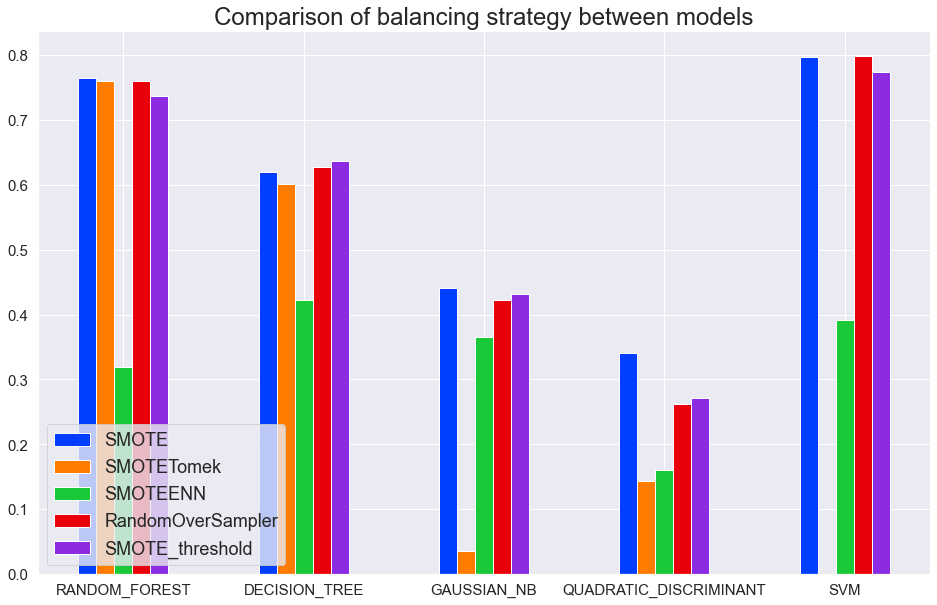

In [22]:
barplot_multiple_columns(df['model_name'].unique(), df['balance'].unique(), data,
                         'Comparison of balancing strategy between models')

## Show class distribution with the best balancing method

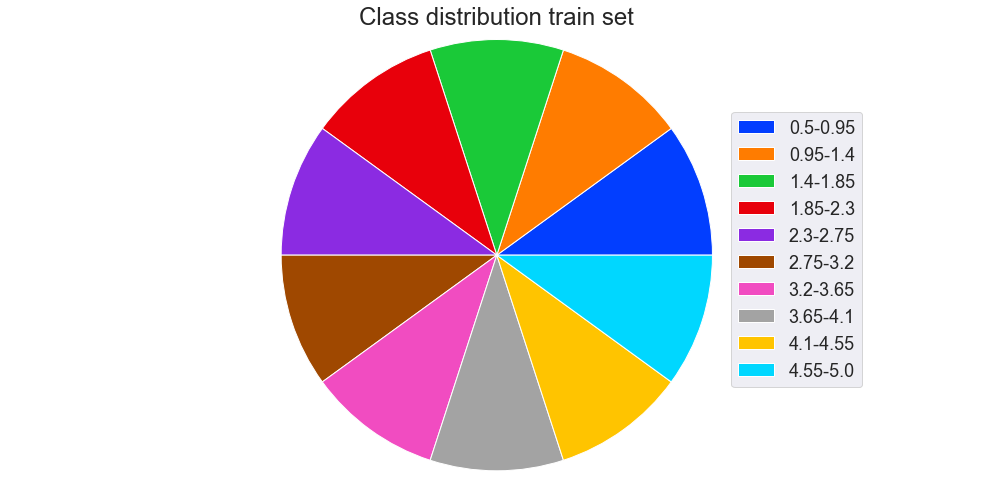

In [23]:
show_class_distribution(train_target_smt_tom)